In [1]:
from mpc import *
from IPython.display import display, Markdown, Latex

### Simulation parameters
Defines the total simulation time and sampling time.

In [2]:
# Total simulation time: 24h (1440m)
total_time = 1440  

# Sampling time: 1m
t_step = 1

# Number of control step: total_time/t_step = 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# Initial conditions
x_0 = np.array([30, 50, 400, 125, 0, 0])

# References
LacI_ref = 750
TetR_ref = 300


### Control loop
It defines the parameters of the controller, instantiates the object of the model class to be controlled and the object of the controller class and starts the control loop.

In [3]:
%%capture

setup_mpc = {
    'n_robust': 1,
    'n_horizon': 10, # Time horizon
    't_step': t_step,
    'store_full_solution': False,
}

toggle = ToggleSwitchModel(True, LacI_ref, TetR_ref, t_step, total_time, avg_period)
mpc_controller = ControllerMPC(toggle, t_step, setup_mpc, True)
mpc_controller.control_loop(x_0, steps, 'stochastic', 10)


### Performance metrics and results plot
It calculates ISE and ITAE values and plots closed-loop simulations.

#### Performance metrics


<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | 32.94     |
| ITAE       | 8.14e+04    |


#### Results plot

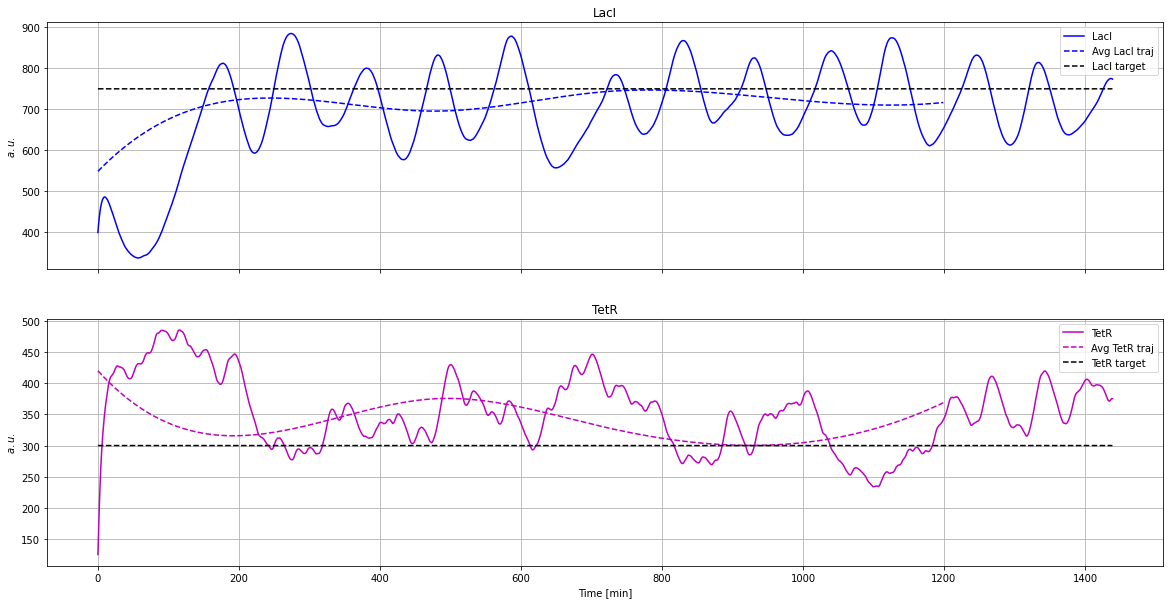

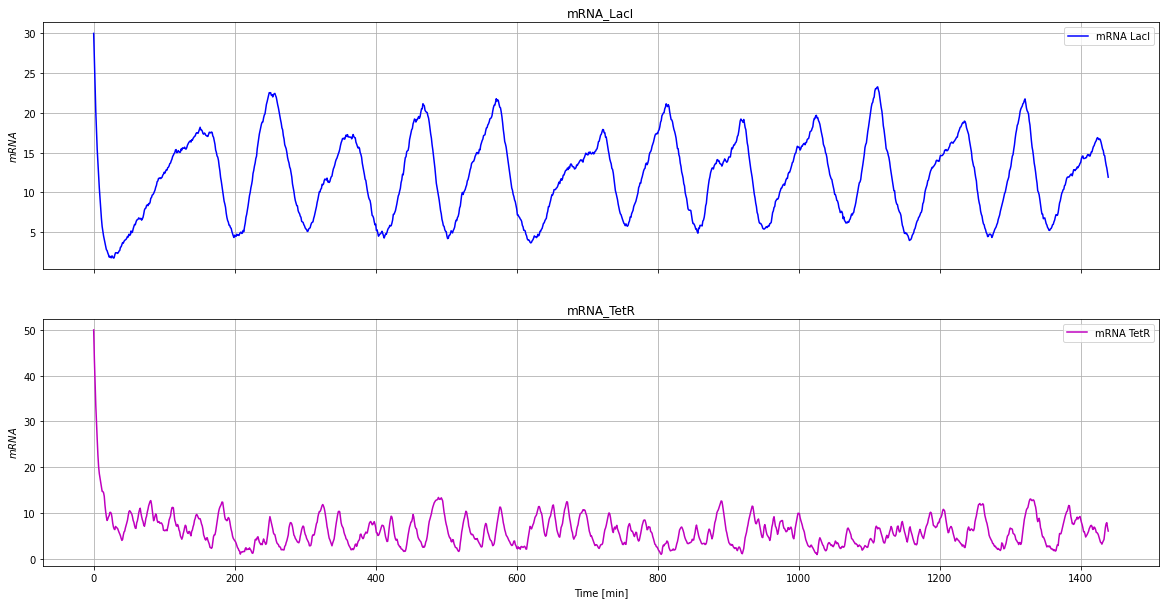

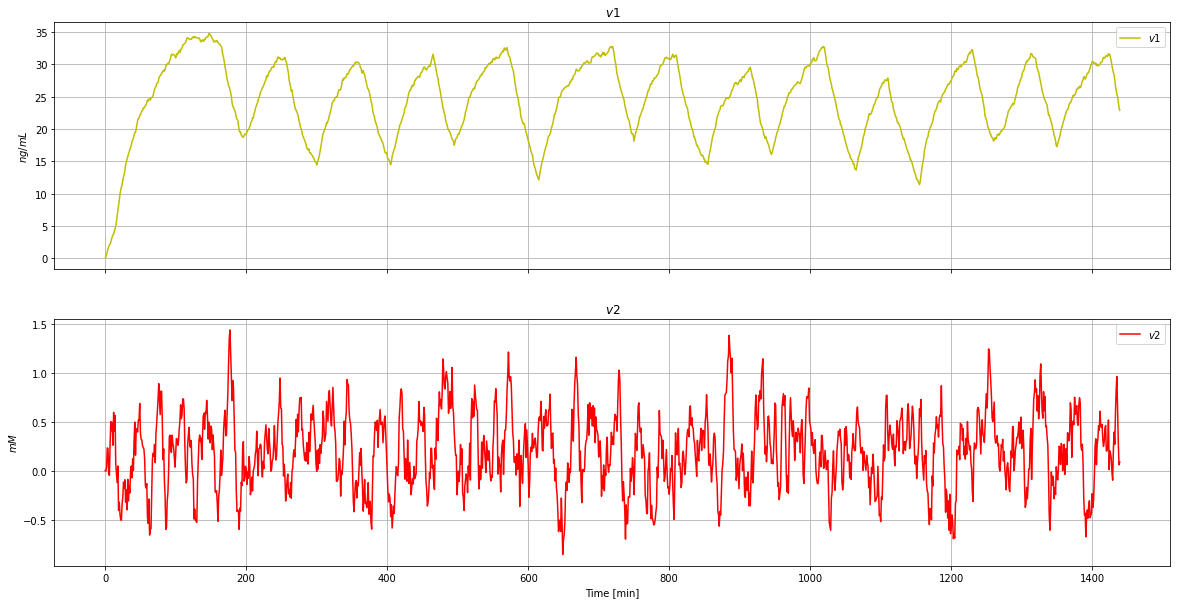

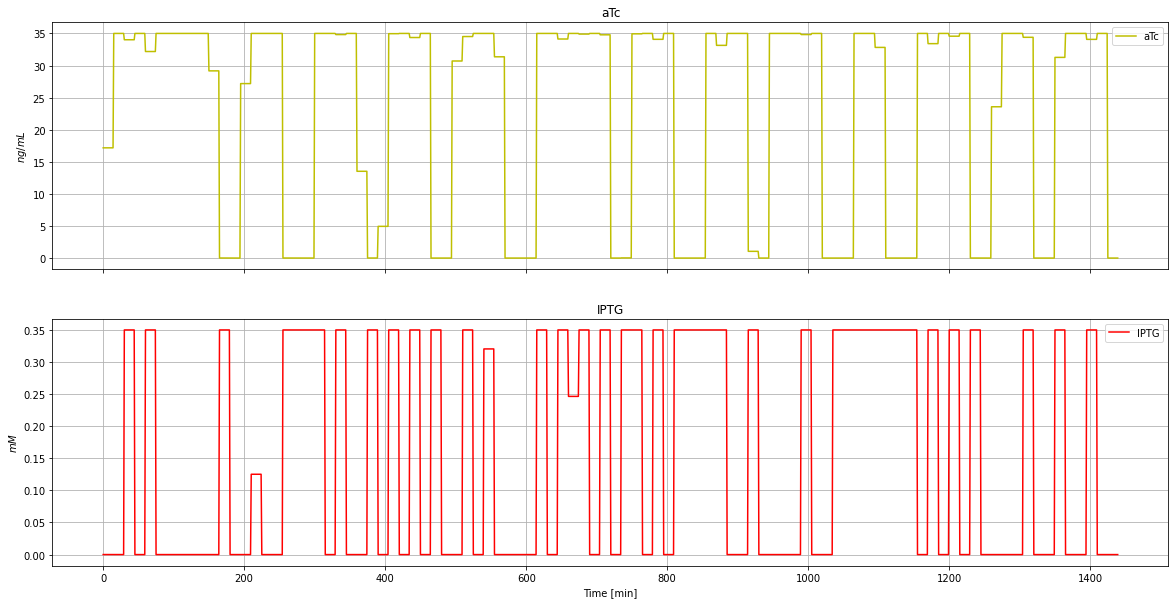

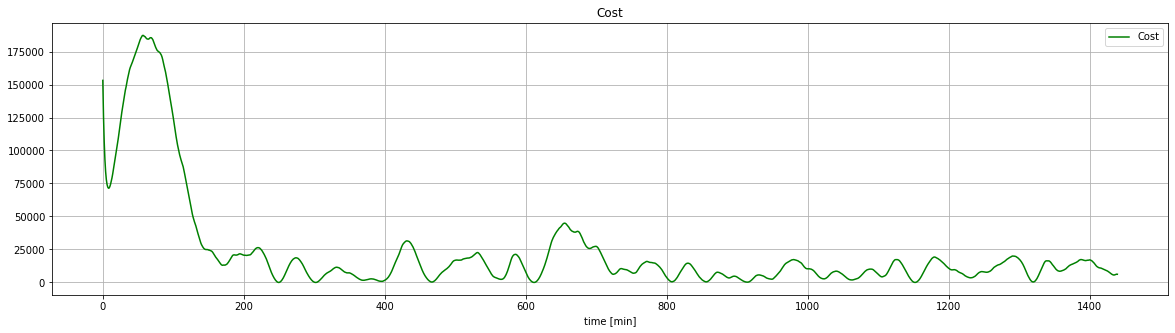

In [4]:
display(Markdown('#### Performance metrics'))
metrics = """
<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | {ISE}     |
| ITAE       | {ITAE}    |
""".format(ISE = "{:.2f}".format(toggle.trajectories['ISE']), ITAE = format(toggle.trajectories['ITAE'], '.2e'))

display(Markdown(metrics))

display(Markdown('#### Results plot'))
figures, lines = toggle.plot_results()


### Plots animation
It animates closed-loop simulations and exports them in mp4 format.

In [5]:
toggle.animate_results('stochastic', 'proteins', toggle.update_protein, figures[0], (toggle.trajectories, lines[0:6], np.arange(0, total_time - ((total_time-1) % avg_period) - 1, t_step)), steps)
toggle.animate_results('stochastic', 'mRNAs', toggle.update_mRNA, figures[1], (toggle.trajectories, lines[6:8]), steps)
toggle.animate_results('stochastic', 'internal_inducers', toggle.update_internal_inducers, figures[2], (toggle.trajectories, lines[8:10]), steps)
toggle.animate_results('stochastic', 'external_inducers', toggle.update_external_inducers, figures[3], (toggle.trajectories, lines[10:12]), steps)
toggle.animate_results('stochastic', 'cost', toggle.update_cost, figures[4], (toggle.trajectories, lines[12:13]), steps)

### Mean and standard deviation of state trajectories

In this section the mean and the standard deviation of the state trajectories are computed and plotted, starting from the results of the previous simulations.

In [6]:
episodes = 10

samples = int(total_time/t_step)

states = np.empty((episodes, samples, 6))

for i in range(episodes):
    with open('./data/stochastic/results' + str(i) + '.json') as f:
        data = json.load(f)
        states[i, :, 0] = data['states']['mRNA_LacI']
        states[i, :, 1] = data['states']['mRNA_TetR']
        states[i, :, 2] = data['states']['LacI']
        states[i, :, 3] = data['states']['TetR']
        states[i, :, 4] = data['states']['v1']
        states[i, :, 5] = data['states']['v2']

# Average trajectories among all episodes
states_mean = np.array([[np.mean(states[:, i, 0]), np.mean(states[:, i, 1]), np.mean(states[:, i, 2]), np.mean(
    states[:, i, 3]), np.mean(states[:, i, 4]), np.mean(states[:, i, 5])] for i in range(steps)])

# Average trajectory for each state in each episode
avg_samples_range = int(avg_period/t_step)
avg_x = np.arange(0, total_time, avg_period)
avg_stop_time = total_time - ((total_time-1) % avg_period) - 1
avg_time = np.arange(0, avg_stop_time, t_step)

states_average = np.zeros((episodes, avg_stop_time, 6))

for i in range(episodes):

    for j in range(6):

        x_avg = [np.mean(states[i, x:x + avg_samples_range, j]) for x in range(0, steps, avg_samples_range)]
        fx_avg = CubicSpline(avg_x, x_avg)
        states_average[i, :, j] = fx_avg(avg_time)

# Mean of average trajectories
mean = np.zeros((avg_stop_time, 6))
std = np.zeros((avg_stop_time, 6))

for i in range(avg_stop_time):
    for j in range(6):
        mean[i, j] = np.mean(states_average[:, i, j])
        std[i, j] = np.std(states_average[:, i, j])

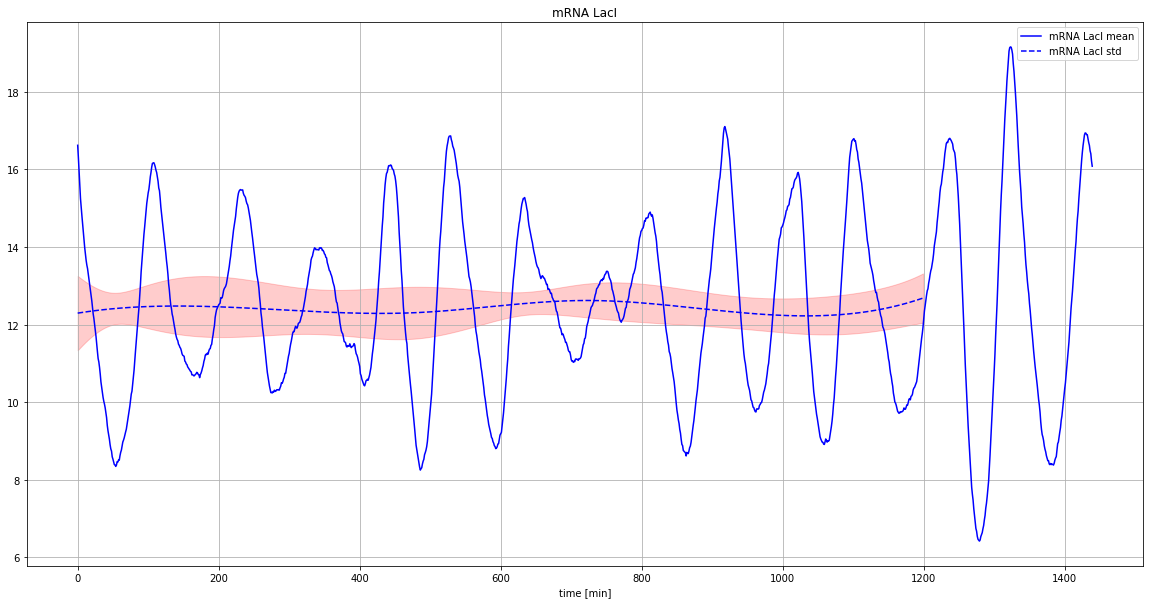

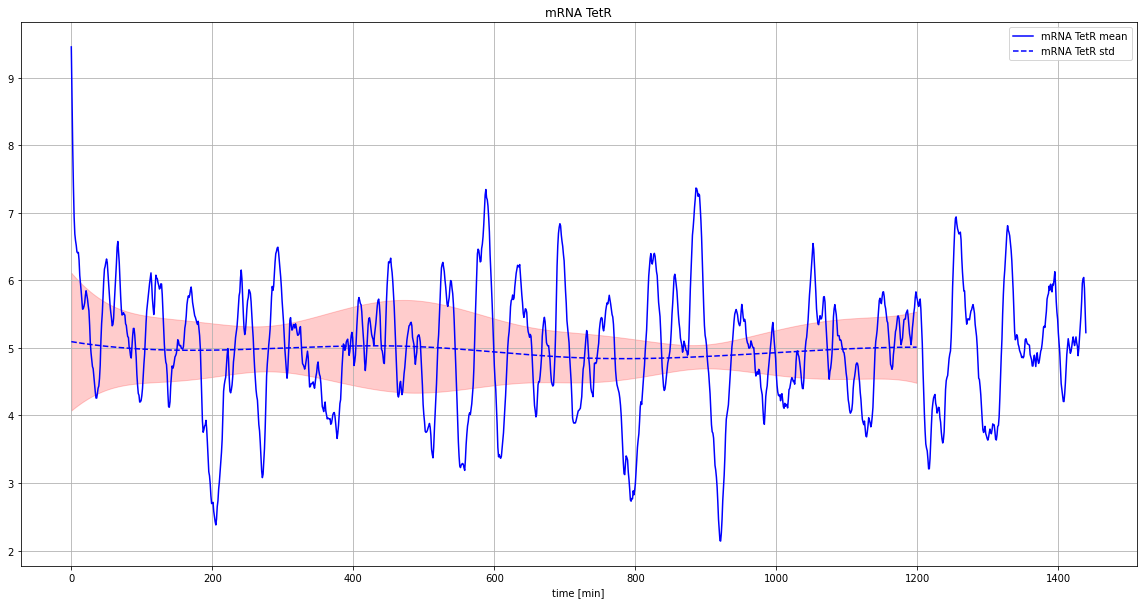

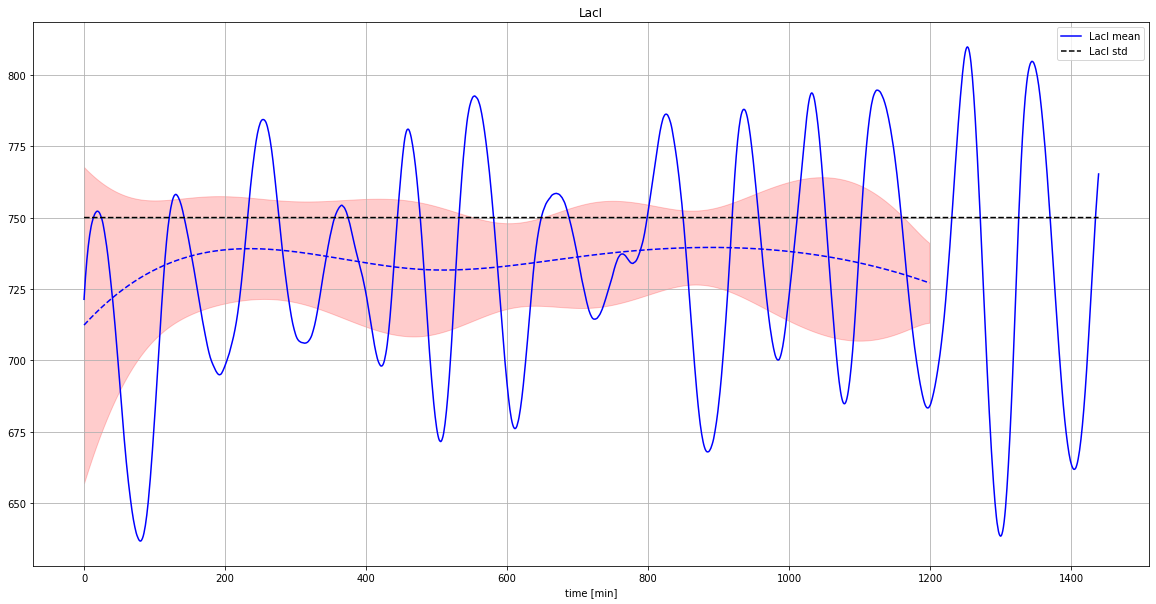

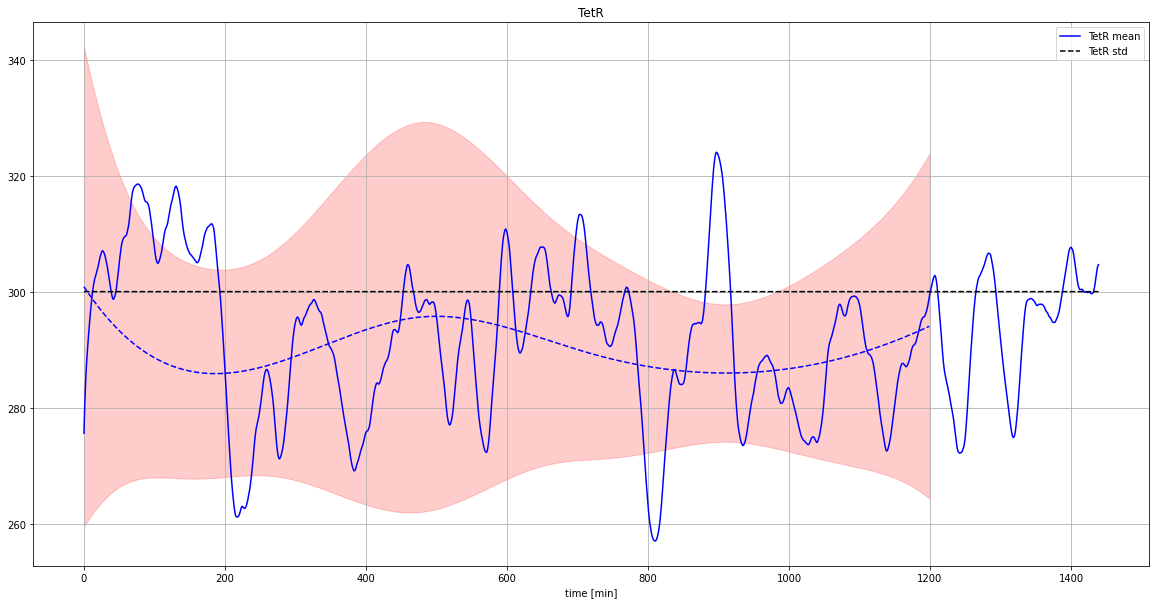

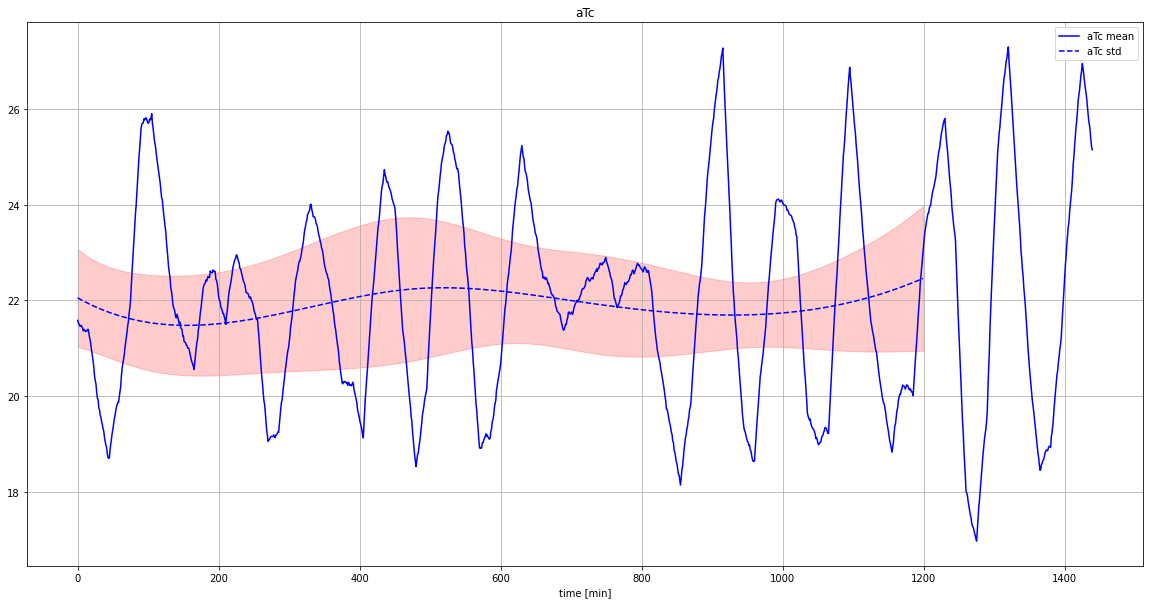

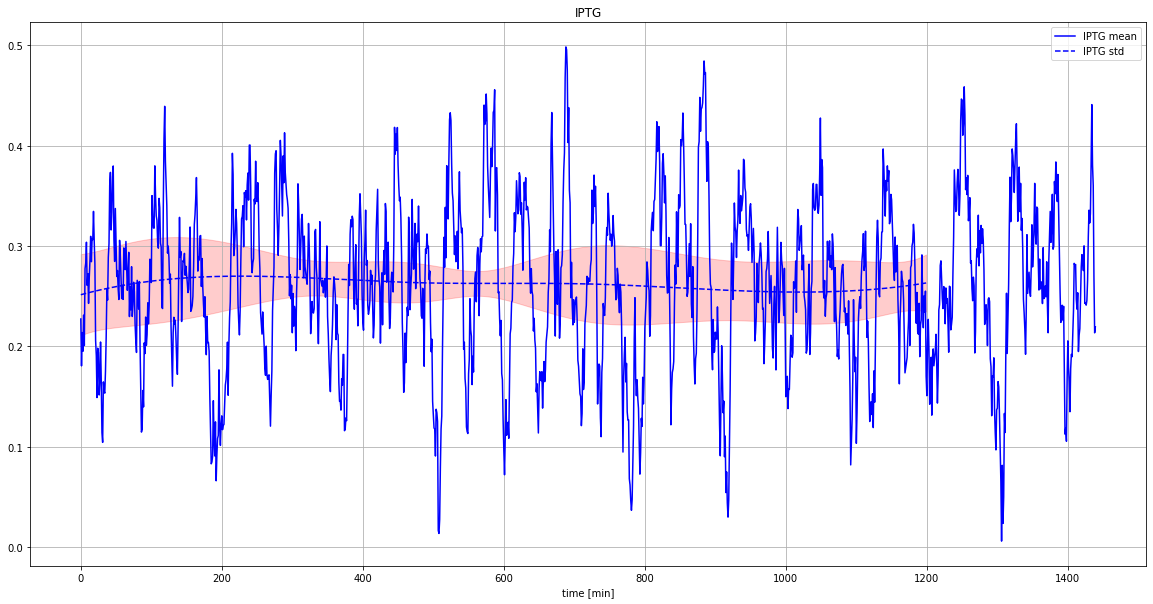

In [7]:
fig_x = 20
fig_y = 10

time = data['time']

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('mRNA LacI')
axes.plot(time, states_mean[:, 0], color='b')
axes.plot(avg_time, mean[:, 0], color='b', linestyle='--')
axes.fill_between(avg_time, mean[:, 0] - std[:, 0], mean[:, 0] + std[:, 0], color='r', alpha=0.2)
axes.legend(['mRNA LacI mean', 'mRNA LacI std'], loc='upper right')
axes.set_xlabel('time [min]')

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/mRNA_LacI.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))
axes.set_ylabel('')
axes.set_title('mRNA TetR')
axes.plot(time, states_mean[:, 1], color='b')
axes.plot(avg_time, mean[:, 1], color='b', linestyle='--')
axes.fill_between(avg_time, mean[:, 1] - std[:, 1], mean[:, 1] + std[:, 1], color='r', alpha=0.2)
axes.legend(['mRNA TetR mean', 'mRNA TetR std'], loc='upper right')
axes.set_xlabel('time [min]')


figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/mRNA_TetR.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('LacI')
axes.plot(time, states_mean[:, 2], color='b')
axes.plot(time, LacI_ref*np.ones(len(time)), color='k', linestyle='--')
axes.plot(avg_time, mean[:, 2], color='b', linestyle='--')
axes.fill_between(avg_time, mean[:, 2] - std[:, 2], mean[:, 2] + std[:, 2], color='r', alpha=0.2)
axes.legend(['LacI mean', 'LacI std'], loc='upper right')
axes.set_xlabel('time [min]')


figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/LacI.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('TetR')
axes.plot(time, states_mean[:, 3], color='b')
axes.plot(time, TetR_ref*np.ones(len(time)), color='k', linestyle='--')
axes.plot(avg_time, mean[:, 3], color='b', linestyle='--')
axes.fill_between(avg_time, mean[:, 3] - std[:, 3], mean[:, 3] + std[:, 3], color='r', alpha=0.2)
axes.legend(['TetR mean', 'TetR std'], loc='upper right')
axes.set_xlabel('time [min]')


figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/TetR.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('aTc')
axes.plot(time, states_mean[:, 4], color='b')
axes.plot(avg_time, mean[:, 4], color='b', linestyle='--')
axes.fill_between(avg_time, mean[:, 4] - std[:, 4], mean[:, 4] + std[:, 4], color='r', alpha=0.2)
axes.legend(['aTc mean', 'aTc std'], loc='upper right')
axes.set_xlabel('time [min]')


figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/aTc.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('IPTG')
axes.plot(time, states_mean[:, 5], color='b')
axes.plot(avg_time, mean[:, 5], color='b', linestyle='--')
axes.fill_between(avg_time, mean[:, 5] - std[:, 5], mean[:, 5] + std[:, 5], color='r', alpha=0.2)
axes.legend(['IPTG mean', 'IPTG std'], loc='upper right')
axes.set_xlabel('time [min]')

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/IPTG.png')
